In [ ]:
import pandas as pd
import numpy as np
from Auxiliary_functions import create_agreggated_files

Error parsing backtester output: [Errno 2] No such file or directory: 'C:\\Users\\ramon\\OneDrive\\Desktop\\Python projects\\Trading\\Prosperity 3\\round1\\backtests\\Logfile_OUR_DATA.log'
Market Data (Activities log) head:
   day  timestamp           product  bid_price_1  bid_volume_1  bid_price_2  \
0    0          0  RAINFOREST_RESIN         9998             1       9995.0   
1    0          0              KELP         2028            30          NaN   
2    0        100              KELP         2030             4       2028.0   
3    0        100  RAINFOREST_RESIN         9996             1       9995.0   
4    0        200  RAINFOREST_RESIN         9996             1       9995.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0          30.0          NaN           NaN        10005            30   
1           NaN          NaN           NaN         2032            30   
2          31.0          NaN           NaN         2032            31   
3        

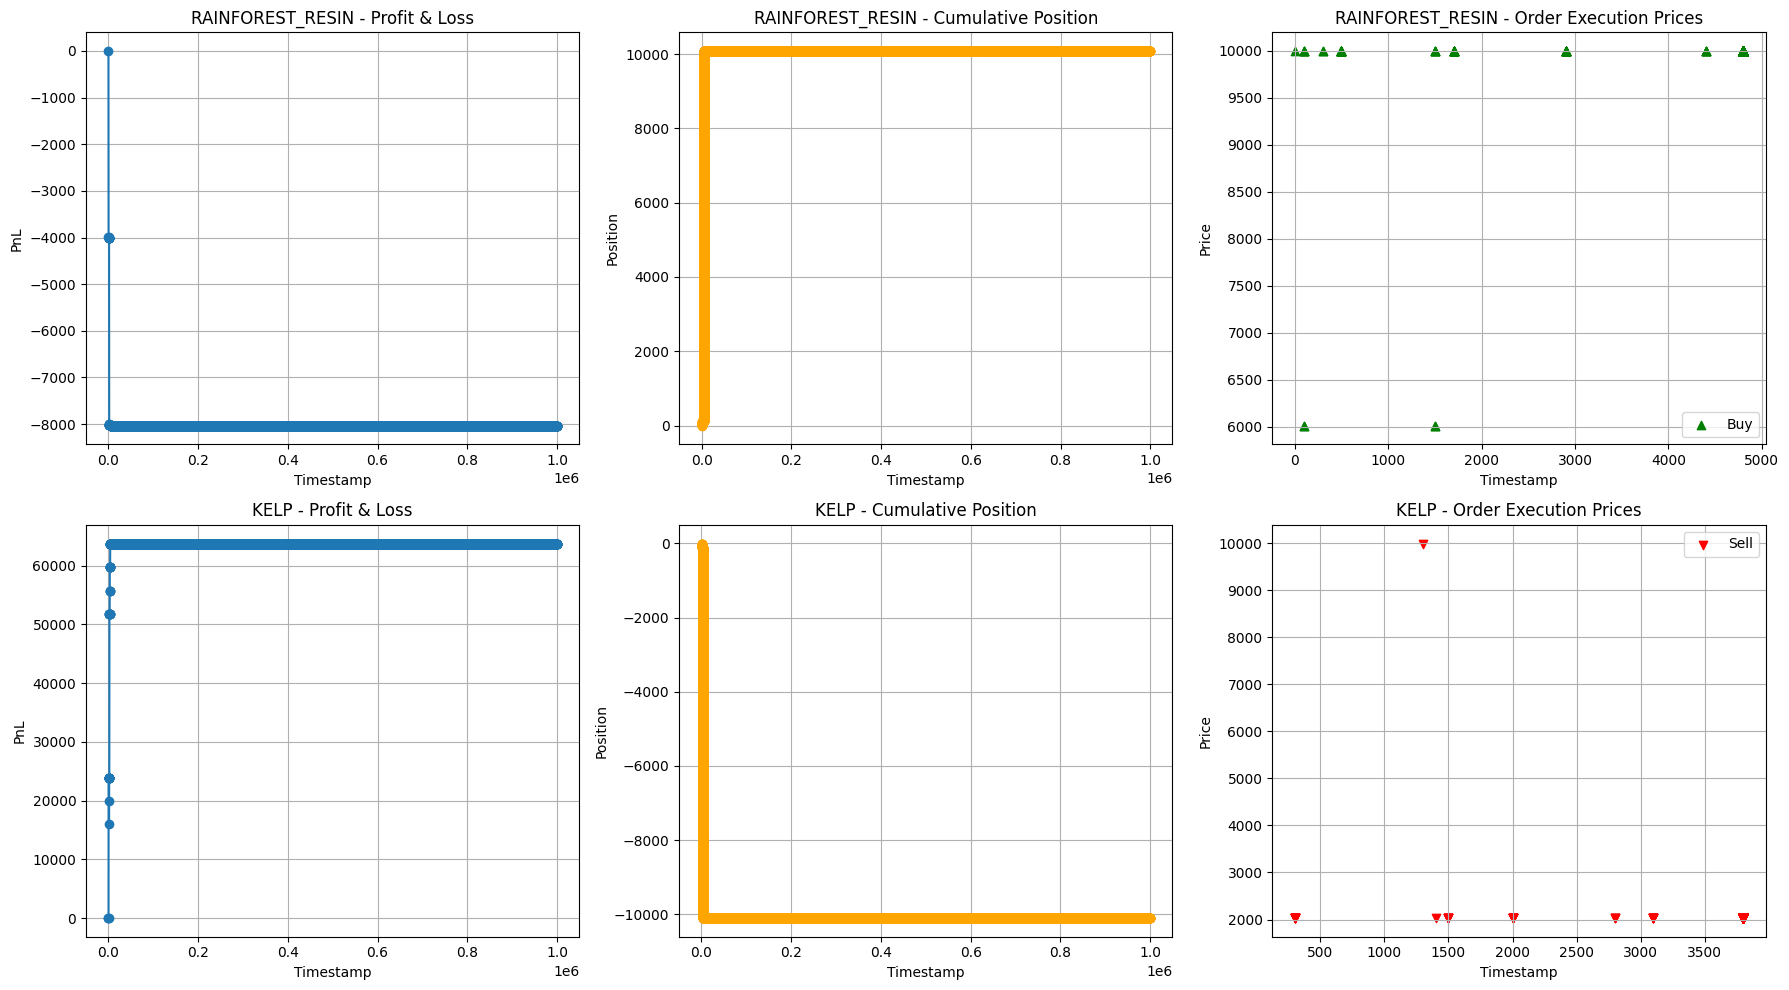

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import json
import io

def parse_backtester_output(file_path):
    """
    Parses the backtester output file into a market data DataFrame and a trade history list.
    
    The output file is expected to contain three sections:
      - Sandbox logs (ignored)
      - Activities log: a CSV section starting with the header line after "Activities log:"
      - Trade History: a JSON array starting after "Trade History:"
    
    Parameters:
      file_path (str): Path to the backtester output file.
    
    Returns:
      market_data (pd.DataFrame): The activities log parsed into a DataFrame.
      trades (list): The trade history parsed as a list of dictionaries.
    """
    with open(file_path, "r") as f:
        content = f.read()
    
    # Split sections based on markers
    # We use the markers "Activities log:" and "Trade History:" as delimiters.
    # First, split off sandbox logs.
    parts = content.split("Activities log:")
    if len(parts) < 2:
        raise ValueError("Activities log section not found.")
    # The second part has CSV + other sections; now split the CSV and trade history.
    activities_and_rest = parts[1]
    activities_part, *rest = activities_and_rest.split("Trade History:")
    if not rest:
        raise ValueError("Trade History section not found.")
    trade_history_part = rest[0]
    
    # The Activities log portion is in CSV format.
    # Sometimes there might be leading/trailing whitespace or extra newlines.
    csv_text = activities_part.strip()
    # Read CSV using semicolon as delimiter.
    market_data = pd.read_csv(io.StringIO(csv_text), delimiter=";")
    
    # The Trade History portion is a JSON array.
    trade_history_text = trade_history_part.strip()
    # In case there are extra characters before/after the JSON (e.g. newlines), try to extract the JSON starting with '[':
    json_start = trade_history_text.find('[')
    if json_start == -1:
        raise ValueError("JSON start '[' not found in Trade History section.")
    json_text = trade_history_text[json_start:]
    trades = json.loads(json_text)
    
    return market_data, trades

def plot_backtest_results(market_data: pd.DataFrame, trades: list):
    """
    Graph metrics for each product using market data and trade history.
    
    This function creates three subplots per product:
      1) Profit & Loss (PnL) over time.
      2) Cumulative position computed from the trade history.
      3) Trade execution prices, marking buys and sells.
    
    Parameters:
      market_data: DataFrame containing at least the following columns:
                   - 'timestamp': time of the market snapshot.
                   - 'product': product identifier.
                   - 'profit_and_loss': PnL at that snapshot.
      trades: List of trade dictionaries, each with keys:
              'timestamp', 'buyer', 'seller', 'symbol' (product), 'price', 'quantity'.
    """
    
    # Sort the market data by timestamp.
    market_data = market_data.sort_values('timestamp')
    
    # Extract the unique products (assumed to be in the 'product' column)
    products = market_data['product'].unique()
    n_products = len(products)
    
    # Create a figure with one row per product and three columns for each subplot.
    fig, axs = plt.subplots(n_products, 3, figsize=(18, 5 * n_products), squeeze=False)
    
    # Convert the trade list into a DataFrame and sort by timestamp.
    trades_df = pd.DataFrame(trades)
    trades_df.sort_values('timestamp', inplace=True)
    
    for i, product in enumerate(products):
        # Filter market_data and trades for the current product.
        prod_market = market_data[market_data['product'] == product]
        prod_trades = trades_df[trades_df['symbol'] == product].copy()
        
        # --- PnL Plot ---
        ax = axs[i][0]
        ax.plot(prod_market['timestamp'], prod_market['profit_and_loss'], marker='o', linestyle='-')
        ax.set_title(f"{product} - Profit & Loss")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("PnL")
        ax.grid(True)
        
        # --- Cumulative Position Plot ---
        # We compute the position change based on trades.
        # We assume that when your algorithm is the buyer (with "SUBMISSION" on seller),
        # the position increases, and when it is the seller (with "SUBMISSION" on buyer), it decreases.
        def position_change(row):
            if row['seller'] == "SUBMISSION":
                return row['quantity']
            elif row['buyer'] == "SUBMISSION":
                return -row['quantity']
            else:
                return 0
        
        if not prod_trades.empty:
            prod_trades['position_change'] = prod_trades.apply(position_change, axis=1)
            prod_trades['cumulative_position'] = prod_trades['position_change'].cumsum()
        else:
            # If no trades exist for this product, create a dummy timeline with zero positions.
            prod_trades = pd.DataFrame({
                'timestamp': prod_market['timestamp'],
                'cumulative_position': 0
            })

        ax = axs[i][1]
        ax.plot(prod_trades['timestamp'], prod_trades['cumulative_position'], marker='o', linestyle='-', color='orange')
        ax.set_title(f"{product} - Cumulative Position")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Position")
        ax.grid(True)
        
        # --- Order / Trade Prices Plot ---
        # Separate the trade markers into buys and sells.
        buys = prod_trades[prod_trades['position_change'] > 0]
        sells = prod_trades[prod_trades['position_change'] < 0]

        ax = axs[i][2]
        if not buys.empty:
            ax.scatter(buys['timestamp'], buys['price'], marker='^', color='green', label="Buy")
        if not sells.empty:
            ax.scatter(sells['timestamp'], sells['price'], marker='v', color='red', label="Sell")
        ax.set_title(f"{product} - Order Execution Prices")
        ax.set_xlabel("Timestamp")
        ax.set_ylabel("Price")
        ax.grid(True)
        ax.legend()
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Adjust the file path below to your backtester output file.
    output_file = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\backtests\Logfile_OUR_DATA.log"
    #output_file = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\Last year\logfile.log"
    
    try:
        market_data, trades = parse_backtester_output(output_file)
    except Exception as e:
        print("Error parsing backtester output:", e)
        exit(1)
    
    # Optional: display first few rows of each DataFrame for verification
    print("Market Data (Activities log) head:")
    print(market_data.head())
    print("\nTrade History head:")
    print(pd.DataFrame(trades).head())
    
    plot_backtest_results(market_data, trades)


Market Data (Activities log) head:
   day  timestamp    product  bid_price_1  bid_volume_1  bid_price_2  \
0    0          0  AMETHYSTS         9998             1       9995.0   
1    0          0  STARFRUIT         5036            30          NaN   
2    0        100  AMETHYSTS         9996             1       9995.0   
3    0        100  STARFRUIT         5041             4       5037.0   
4    0        200  AMETHYSTS         9996             1       9995.0   

   bid_volume_2  bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
0          30.0          NaN           NaN        10005            30   
1           NaN          NaN           NaN         5043            30   
2          30.0          NaN           NaN        10002             6   
3           1.0       5036.0          30.0         5043            31   
4          21.0          NaN           NaN        10004             1   

   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  mid_price  \
0          NaN         

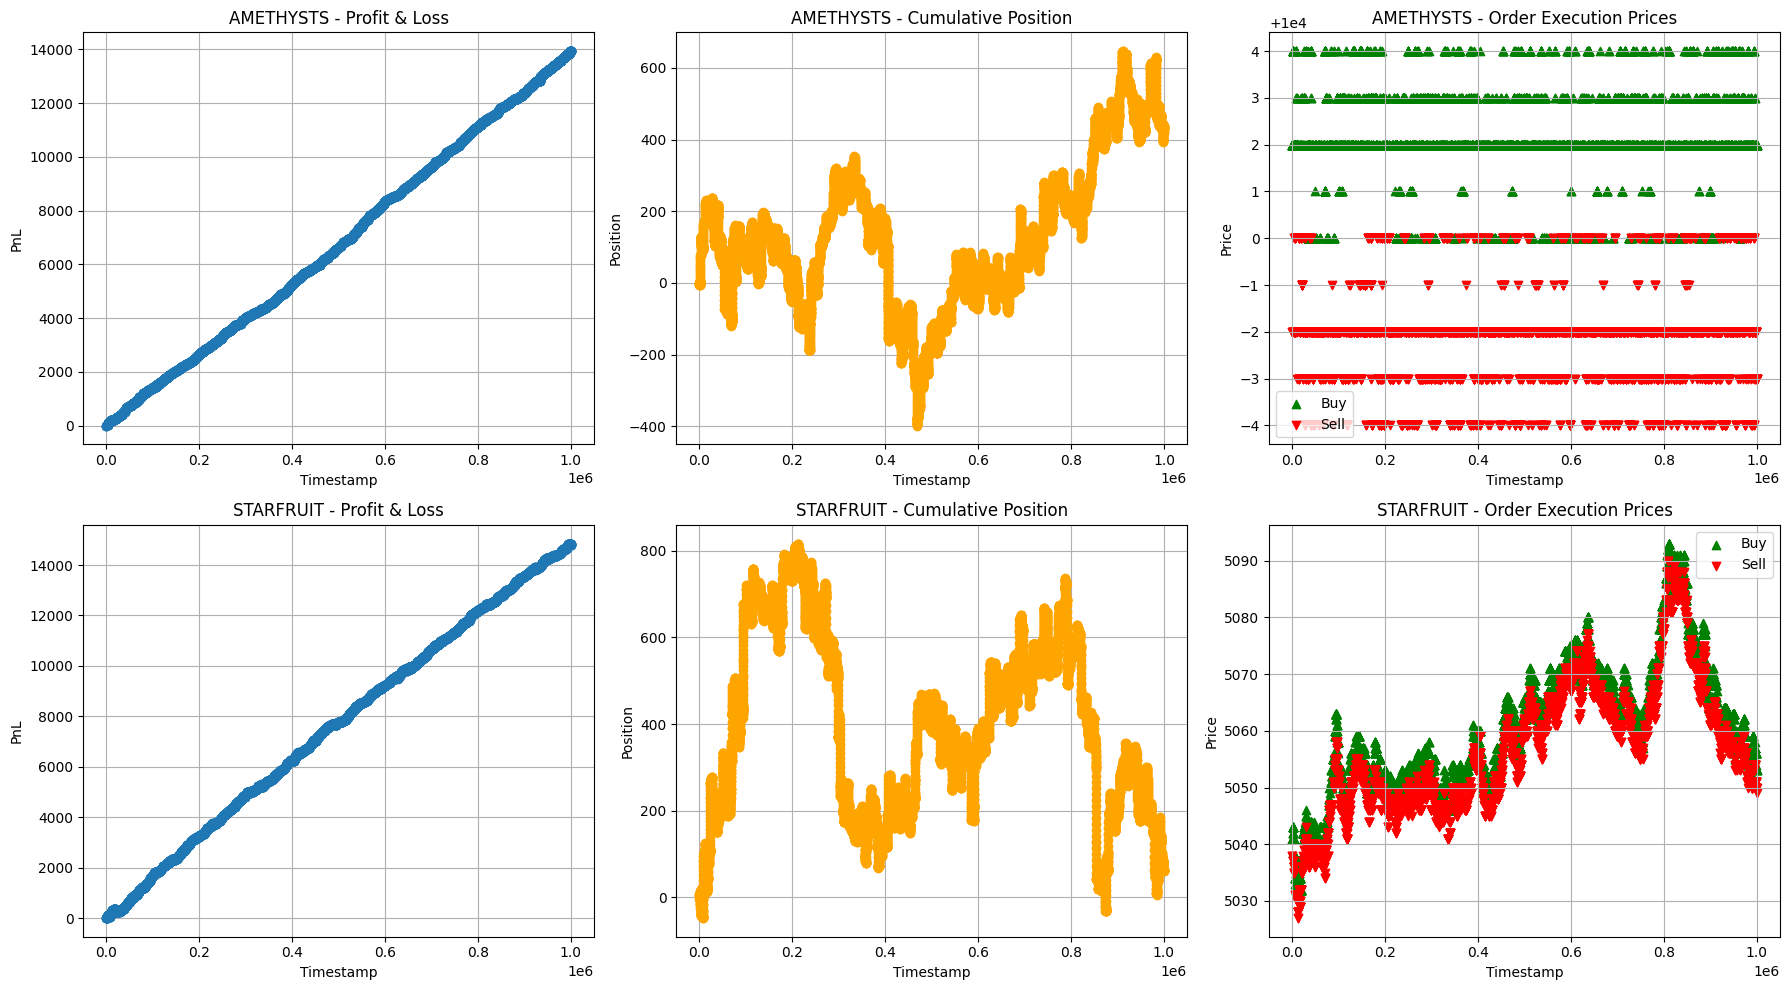

In [17]:
if __name__ == "__main__":
    # Adjust the file path below to your backtester output file.
    output_file = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\round1\backtests\Logfile_OUR_DATA.log"
    output_file = r"C:\Users\ramon\OneDrive\Desktop\Python projects\Trading\Prosperity 3\Last year\logfile.log"
    
    try:
        market_data, trades = parse_backtester_output(output_file)
    except Exception as e:
        print("Error parsing backtester output:", e)
        exit(1)
    
    # Optional: display first few rows of each DataFrame for verification
    print("Market Data (Activities log) head:")
    print(market_data.head())
    print("\nTrade History head:")
    print(pd.DataFrame(trades).head())
    
    plot_metrics(market_data, trades)


In [4]:
import pandas as pd
import os

def create_agreggated_files(comp_round, base_path = rf"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3"):

    # List to store the datafrakmes for all days
    all_market_data = []
    all_trade_history = []

    # Iterate iver the days you want to read
    for day in range(-2, 1):  
        prices_file = os.path.join(base_path, rf"round{comp_round}\data\prices_round_1_day_{day}.csv")
        trades_file = os.path.join(base_path, rf"round{comp_round}\data\trades_round_1_day_{day}.csv")

        try:
            market_data = pd.read_csv(prices_file, sep=";", header=0)
            all_market_data.append(market_data)
        except FileNotFoundError:
            print(f"File {prices_file} was not found\n")

        try:
            trade_history = pd.read_csv(trades_file, sep=";", header=0)
            all_trade_history.append(trade_history)
        except FileNotFoundError:
            print(f"File {trades_file} was not found\n{80*'-'}")

    # Concatena all dataframes 
    market_data_ALL = pd.concat(all_market_data, ignore_index=True)
    trade_history_ALL = pd.concat(all_trade_history, ignore_index=True)

    # Convert the concatenated dataframes to csv
    output_prices_file = os.path.join(base_path, rf"round{comp_round}\data\prices_round_{comp_round}_ALL.csv")
    output_trades_file = os.path.join(base_path, rf"round{comp_round}\data\trades_round_{comp_round}_ALL.csv")

    market_data_ALL.to_csv(output_prices_file, index=False)
    trade_history_ALL.to_csv(output_trades_file, index=False)

    print(f"Concatenated market data stored in: {output_prices_file}\n")
    print(f"Concatenated trade history stored in: {output_trades_file}")

create_agreggated_files(comp_round=1)

Concatenated market data stored in: C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv

Concatenated trade history stored in: C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\trades_round_1_ALL.csv


In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace this with your actual data)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv",sep=";",header=0)

df = pd.DataFrame(market_data)

# Convert 'day' and 'timestamp' into a datetime object
df['datetime'] = pd.to_datetime(df['day'] + ' ' + df['timestamp'])

# Plotting function
def plot_market_data(df, product):
    # Filter data for the selected product
    product_data = df[df['product'] == product]

    # Create subplots
    fig, ax1 = plt.subplots(figsize=(10, 8))

    # Plot bid and ask prices
    ax1.plot(product_data['datetime'], product_data['bid_price_1'], label='Bid Price 1', color='blue')
    ax1.plot(product_data['datetime'], product_data['ask_price_1'], label='Ask Price 1', color='red')
    ax1.plot(product_data['datetime'], product_data['bid_price_2'], label='Bid Price 2', color='cyan')
    ax1.plot(product_data['datetime'], product_data['ask_price_2'], label='Ask Price 2', color='orange')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')

    # Create a second y-axis for volume
    ax2 = ax1.twinx()
    ax2.bar(product_data['datetime'], product_data['bid_volume_1'], label='Bid Volume 1', color='blue', alpha=0.3, width=0.05)
    ax2.bar(product_data['datetime'], product_data['ask_volume_1'], label='Ask Volume 1', color='red', alpha=0.3, width=0.05)
    ax2.bar(product_data['datetime'], product_data['bid_volume_2'], label='Bid Volume 2', color='cyan', alpha=0.3, width=0.05)
    ax2.bar(product_data['datetime'], product_data['ask_volume_2'], label='Ask Volume 2', color='orange', alpha=0.3, width=0.05)
    ax2.set_ylabel('Volume')

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.title(f'Market Data for Product {product}')
    plt.show()

# Call the plotting function for each product
products = df['product'].unique()
for product in products:
    plot_market_data(df, product)

KeyError: 'day'

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace this with your actual data)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv",sep=",",header=0)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_day_0.csv",sep=";",header=0)


df = pd.DataFrame(market_data)


# Create a unique time index by combining day and timestamp
df['time_index'] = df['day'].astype(str) + '-' + df['timestamp'].astype(str)

In [4]:
market_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,0,0,RAINFOREST_RESIN,9998,1,9995.0,30.0,NaN,NaN,10005,30,NaN,NaN,NaN,NaN,10001.5,0.0
1,0,0,KELP,2028,30,NaN,NaN,NaN,NaN,2032,30,NaN,NaN,NaN,NaN,2030.0,0.0
2,0,0,SQUID_INK,1968,30,NaN,NaN,NaN,NaN,1971,30,NaN,NaN,NaN,NaN,1969.5,0.0
3,0,100,SQUID_INK,1969,4,1967.0,31.0,NaN,NaN,1971,31,NaN,NaN,NaN,NaN,1970.0,0.0
4,0,100,KELP,2030,4,2028.0,31.0,NaN,NaN,2032,31,NaN,NaN,NaN,NaN,2031.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,999800,KELP,2032,27,NaN,NaN,NaN,NaN,2034,1,2035.0,27.0,NaN,NaN,2033.0,0.0
29996,0,999800,RAINFOREST_RESIN,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
29997,0,999900,RAINFOREST_RESIN,9996,2,9995.0,21.0,NaN,NaN,10004,2,10005.0,21.0,NaN,NaN,10000.0,0.0
29998,0,999900,SQUID_INK,1838,23,NaN,NaN,NaN,NaN,1841,23,NaN,NaN,NaN,NaN,1839.5,0.0


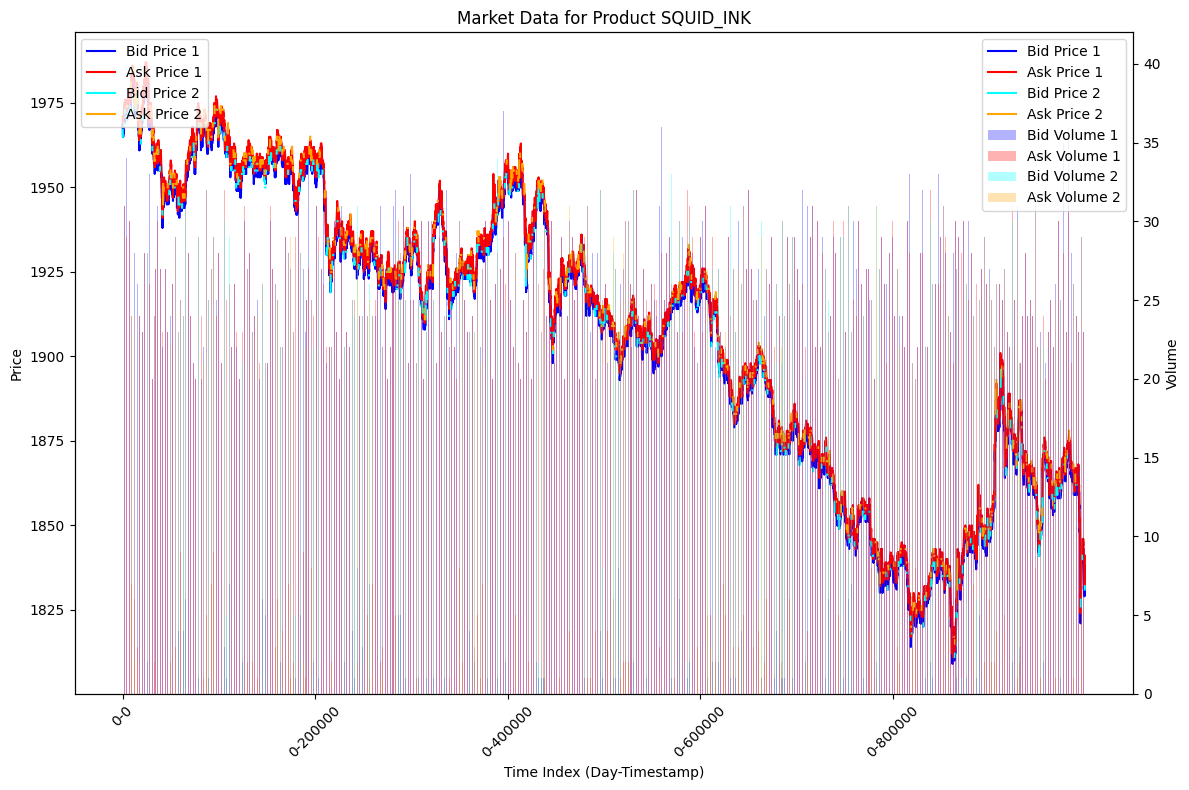

In [7]:


# Plotting function
def plot_market_data(df, product):
    # Filter data for the selected product
    product_data = df[df['product'] == product]

    # Create subplots
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot bid and ask prices
    ax1.plot(product_data['time_index'], product_data['bid_price_1'], label='Bid Price 1', color='blue')
    ax1.plot(product_data['time_index'], product_data['ask_price_1'], label='Ask Price 1', color='red')
    ax1.plot(product_data['time_index'], product_data['bid_price_2'], label='Bid Price 2', color='cyan')
    ax1.plot(product_data['time_index'], product_data['ask_price_2'], label='Ask Price 2', color='orange')
    ax1.set_xlabel('Time Index (Day-Timestamp)')
    ax1.set_ylabel('Price')
    ax1.legend(loc='upper left')

    # Create a second y-axis for volume
    ax2 = ax1.twinx()
    ax2.bar(product_data['time_index'], product_data['bid_volume_1'], label='Bid Volume 1', color='blue', alpha=0.3, width=0.4)
    ax2.bar(product_data['time_index'], product_data['ask_volume_1'], label='Ask Volume 1', color='red', alpha=0.3, width=0.4)
    ax2.bar(product_data['time_index'], product_data['bid_volume_2'], label='Bid Volume 2', color='cyan', alpha=0.3, width=0.4)
    ax2.bar(product_data['time_index'], product_data['ask_volume_2'], label='Ask Volume 2', color='orange', alpha=0.3, width=0.4)
    ax2.set_ylabel('Volume')

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    # Set x-ticks to show fewer labels
    num_labels = 5  # Adjust the number of labels as needed
    x_ticks = range(0, len(product_data['time_index']), len(product_data['time_index']) // num_labels)
    ax1.set_xticks(x_ticks)
    ax1.set_xticklabels(product_data['time_index'].iloc[x_ticks], rotation=45)

    plt.title(f'Market Data for Product {product}')
    plt.tight_layout()
    plt.show()


plot_market_data(df, "SQUID_INK")

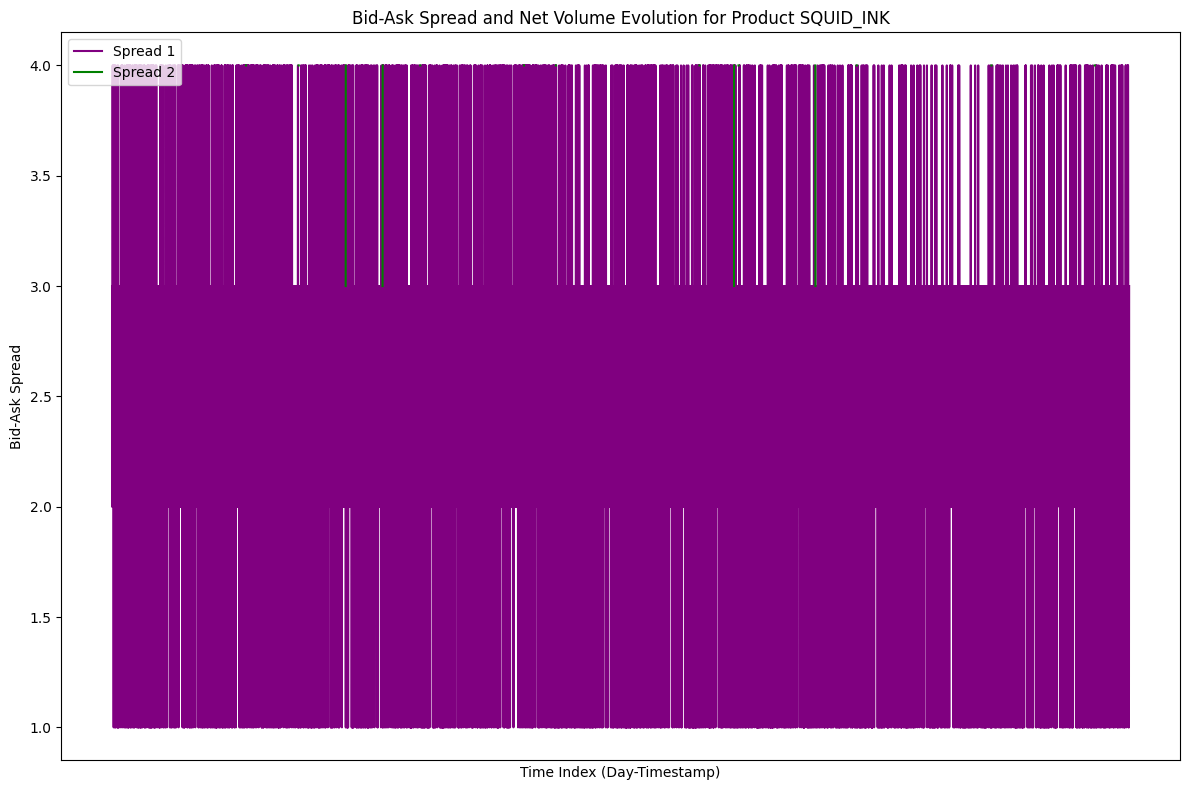

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace this with your actual data)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv",sep=",",header=0)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_day_0.csv",sep=";",header=0)


df = market_data


# Create a unique time index by combining day and timestamp
df['time_index'] = df['day'].astype(str) + '-' + df['timestamp'].astype(str)

# Create a unique time index by combining day and timestamp
df['time_index'] = df['day'].astype(str) + '-' + df['timestamp'].astype(str)

# Calculate bid-ask spreads
df['spread_1'] = df['ask_price_1'] - df['bid_price_1']
df['spread_2'] = df['ask_price_2'] - df['bid_price_2']

# Calculate net volumes
df['net_volume_1'] = df['ask_volume_1'] - df['bid_volume_1']
df['net_volume_2'] = df['ask_volume_2'] - df['bid_volume_2']

# Plotting function
def plot_spreads_and_volumes(df, product):
    # Filter data for the selected product
    product_data = df[df['product'] == product]

    # Create the plot
    fig, ax1 = plt.subplots(figsize=(12, 8))

    # Plot bid-ask spreads
    ax1.plot(product_data['time_index'], product_data['spread_1'], label='Spread 1', color='purple')
    ax1.plot(product_data['time_index'], product_data['spread_2'], label='Spread 2', color='green')
    ax1.set_xlabel('Time Index (Day-Timestamp)')
    ax1.set_ylabel('Bid-Ask Spread')
    ax1.legend(loc='upper left')

    # Create a second y-axis for net volume
    #ax2 = ax1.twinx()
    #ax2.bar(product_data['time_index'], product_data['net_volume_1'], label='Net Volume 1', color='blue', alpha=0.3, width=0.4)
    #ax2.bar(product_data['time_index'], product_data['net_volume_2'], label='Net Volume 2', color='orange', alpha=0.3, width=0.4)
    #ax2.set_ylabel('Net Volume')

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    #lines2, labels2 = ax2.get_legend_handles_labels()
    #ax2.legend(lines + lines2, labels + labels2, loc='upper right')
    
    # Remove x-tick labels
    ax1.set_xticks([])
    # Set x-ticks to show fewer labels
    #num_labels = 5  # Adjust the number of labels as needed
    #x_ticks = range(0, len(product_data['time_index']), max(1, len(product_data['time_index']) // num_labels))
    #ax1.set_xticks(x_ticks)
    #ax1.set_xticklabels(product_data['time_index'].iloc[x_ticks], rotation=45)

    plt.title(f'Bid-Ask Spread and Net Volume Evolution for Product {product}')
    plt.tight_layout()
    plt.show()

plot_spreads_and_volumes(df, "SQUID_INK")

In [20]:
df

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,time_index,spread_1,spread_2,net_volume_1,net_volume_2
0,0,0,RAINFOREST_RESIN,9998,1,9995.0,30.0,NaN,NaN,10005,...,NaN,NaN,NaN,10001.5,0.0,0-0,7,NaN,29,NaN
1,0,0,KELP,2028,30,NaN,NaN,NaN,NaN,2032,...,NaN,NaN,NaN,2030.0,0.0,0-0,4,NaN,0,NaN
2,0,0,SQUID_INK,1968,30,NaN,NaN,NaN,NaN,1971,...,NaN,NaN,NaN,1969.5,0.0,0-0,3,NaN,0,NaN
3,0,100,SQUID_INK,1969,4,1967.0,31.0,NaN,NaN,1971,...,NaN,NaN,NaN,1970.0,0.0,0-100,2,NaN,27,NaN
4,0,100,KELP,2030,4,2028.0,31.0,NaN,NaN,2032,...,NaN,NaN,NaN,2031.0,0.0,0-100,2,NaN,27,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,999800,KELP,2032,27,NaN,NaN,NaN,NaN,2034,...,27.0,NaN,NaN,2033.0,0.0,0-999800,2,NaN,-26,NaN
29996,0,999800,RAINFOREST_RESIN,9995,27,NaN,NaN,NaN,NaN,10005,...,NaN,NaN,NaN,10000.0,0.0,0-999800,10,NaN,0,NaN
29997,0,999900,RAINFOREST_RESIN,9996,2,9995.0,21.0,NaN,NaN,10004,...,21.0,NaN,NaN,10000.0,0.0,0-999900,8,10.0,0,0.0
29998,0,999900,SQUID_INK,1838,23,NaN,NaN,NaN,NaN,1841,...,NaN,NaN,NaN,1839.5,0.0,0-999900,3,NaN,0,NaN


In [18]:
df[df["product"]=="SQUID_INK"]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss,time_index,spread_1,spread_2,net_volume_1,net_volume_2
2,0,0,SQUID_INK,1968,30,NaN,NaN,NaN,NaN,1971,...,NaN,NaN,NaN,1969.5,0.0,0-0,3,NaN,0,NaN
3,0,100,SQUID_INK,1969,4,1967.0,31.0,NaN,NaN,1971,...,NaN,NaN,NaN,1970.0,0.0,0-100,2,NaN,27,NaN
6,0,200,SQUID_INK,1966,1,1965.0,21.0,NaN,NaN,1969,...,NaN,NaN,NaN,1967.5,0.0,0-200,3,NaN,21,NaN
9,0,300,SQUID_INK,1965,25,NaN,NaN,NaN,NaN,1968,...,NaN,NaN,NaN,1966.5,0.0,0-300,3,NaN,0,NaN
14,0,400,SQUID_INK,1966,25,NaN,NaN,NaN,NaN,1968,...,25.0,NaN,NaN,1967.0,0.0,0-400,2,NaN,-19,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29986,0,999500,SQUID_INK,1830,28,NaN,NaN,NaN,NaN,1833,...,NaN,NaN,NaN,1831.5,0.0,0-999500,3,NaN,0,NaN
29989,0,999600,SQUID_INK,1832,7,1831.0,29.0,NaN,NaN,1834,...,27.0,NaN,NaN,1833.0,0.0,0-999600,2,4.0,-5,-2.0
29993,0,999700,SQUID_INK,1834,1,1832.0,26.0,NaN,NaN,1835,...,NaN,NaN,NaN,1834.5,0.0,0-999700,1,NaN,25,NaN
29994,0,999800,SQUID_INK,1837,27,NaN,NaN,NaN,NaN,1839,...,27.0,NaN,NaN,1838.0,0.0,0-999800,2,NaN,-26,NaN


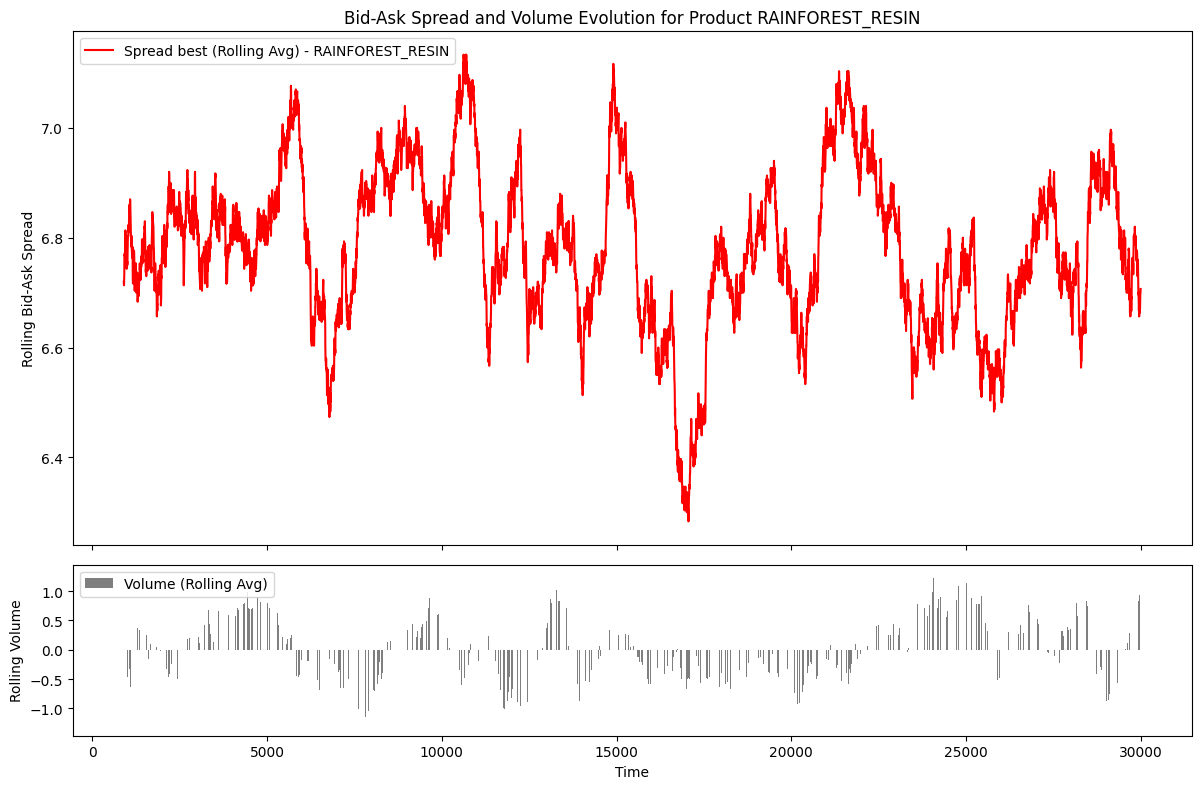

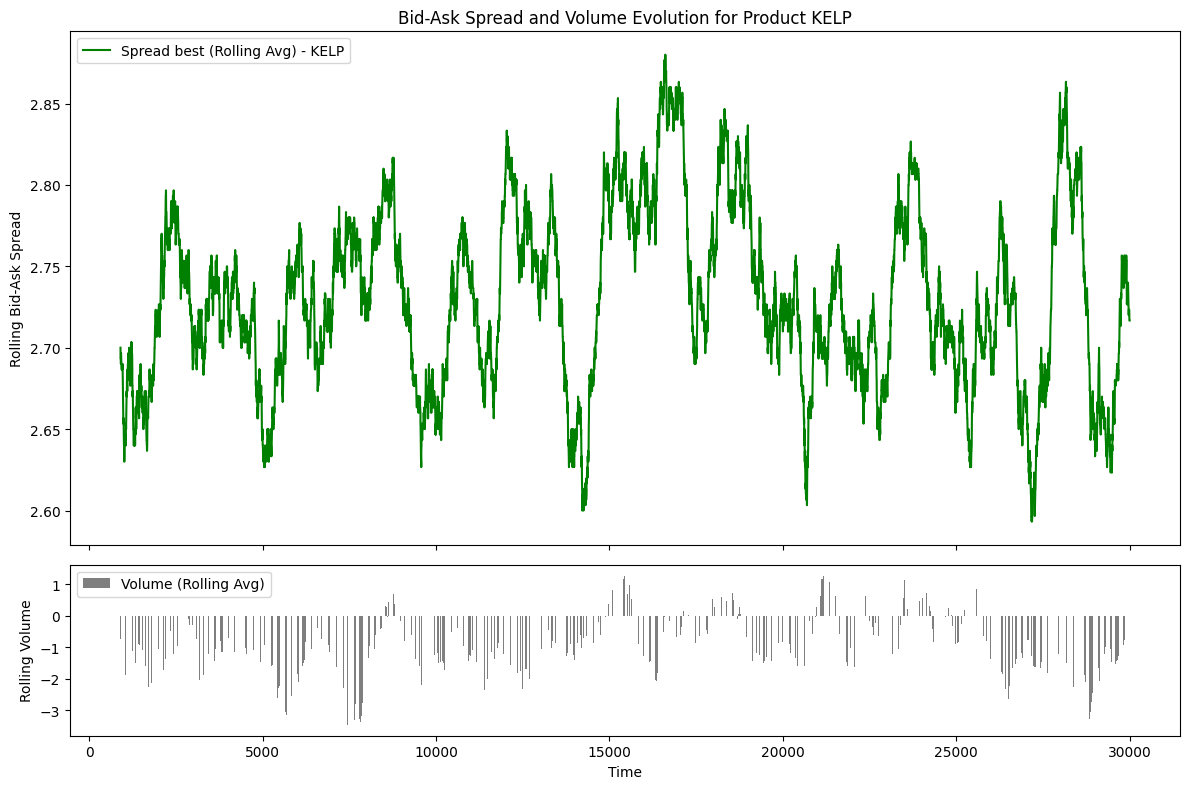

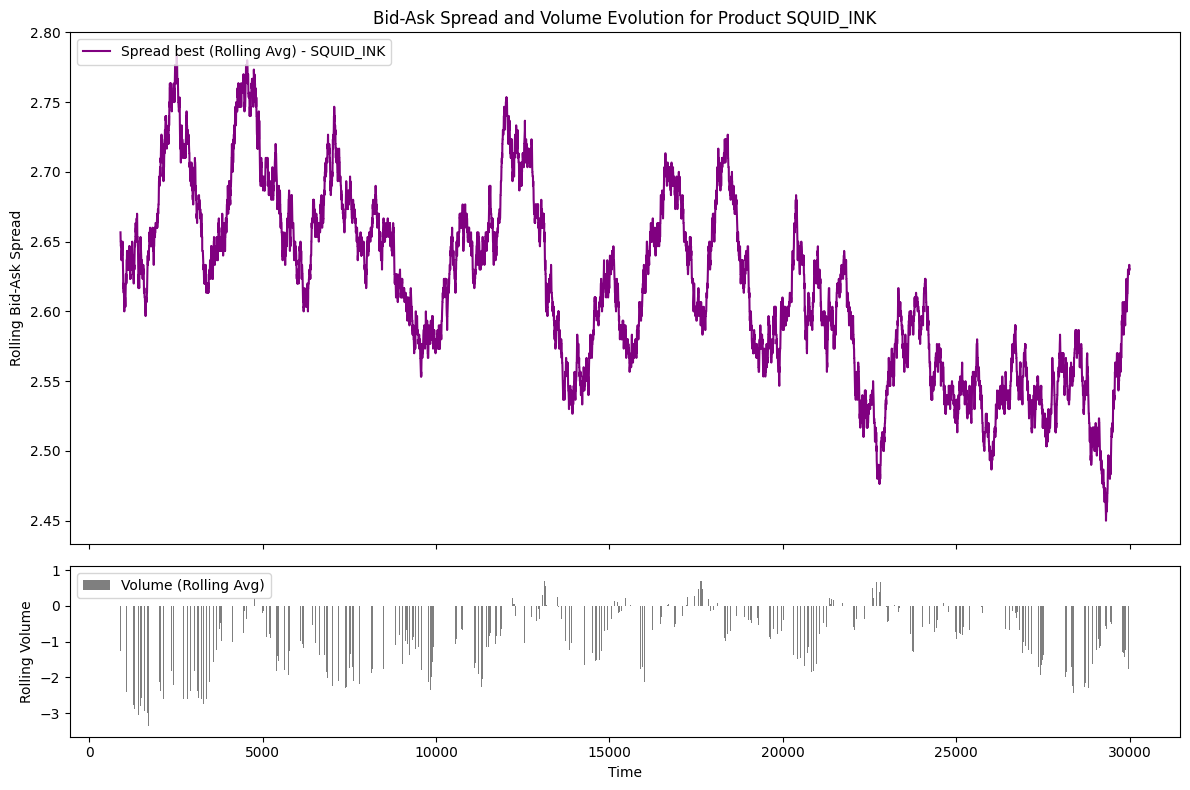

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace this with your actual data)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv",sep=",",header=0)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_day_0.csv",sep=";",header=0)


df = market_data

# Create a unique time index by combining day and timestamp
df['time_index'] = df['day'].astype(str) + '-' + df['timestamp'].astype(str)


for i in range(1,4):
    df[f'spread_{i}'] = np.where(df[f'ask_price_{i}'].notna() & df[f'bid_price_{i}'].notna(),
                          df[f'ask_price_{i}'] - df[f'bid_price_{i}'], np.nan)

'''   
# Calculate spreads with handling NaN
df['spread_1'] = np.where(df['ask_price_1'].notna() & df['bid_price_1'].notna(),
                          df['ask_price_1'] - df['bid_price_1'], np.nan)

df['spread_2'] = np.where(df['ask_price_2'].notna() & df['bid_price_2'].notna(),
                          df['ask_price_2'] - df['bid_price_2'], np.nan)

df['spread_3'] = np.where(df['ask_price_3'].notna() & df['bid_price_3'].notna(),
                          df['ask_price_3'] - df['bid_price_3'], np.nan)
'''
# Calculate best_bid and best_ask
df['ask_price_best'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].min(axis=1)
df['bid_price_best'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].max(axis=1)

# Tightes spread
df['spread_best'] = np.where(df['ask_price_best'].notna() & df['bid_price_best'].notna(),
                          df['ask_price_best'] - df['bid_price_best'], np.nan)

# Initialize columns for best bid/ask volumes
df['ask_volume_best'] = 0
df['bid_volume_best'] = 0

# Determine the best bid/ask volume
for index, row in df.iterrows():
    # Find the best ask volume
    if row['ask_price_best'] == row['ask_price_1']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_1']
    elif row['ask_price_best'] == row['ask_price_2']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_2']
    elif row['ask_price_best'] == row['ask_price_3']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_3']

    # Find the best bid volume
    if row['bid_price_best'] == row['bid_price_1']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_1']
    elif row['bid_price_best'] == row['bid_price_2']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_2']
    elif row['bid_price_best'] == row['bid_price_3']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_3']



# Plotting function
def plot_spreads(df, product, spread = 'best', colors = {"KELP": "green", "RAINFOREST_RESIN":"red", "SQUID_INK":"purple"}):

    color = colors[product]
    # Filter data for the selected product
    product_data = df[df['product'] == product].copy()

    # Calculate rolling averages for smoother visualization
    product_data[f'spread_{spread}_rolling'] = product_data[f'spread_{spread}'].rolling(window=300).mean()

    # Calculate rolling averages for bid and ask volumes
    product_data['bid_volume_rolling'] = product_data[f'bid_volume_{spread}'].rolling(window=300).mean()
    product_data['ask_volume_rolling'] = product_data[f'ask_volume_{spread}'].rolling(window=300).mean()

    # Calculate rolling average for volume
    product_data['net_volume'] = product_data[f'ask_volume_{spread}'] - product_data[f'bid_volume_{spread}']
    product_data['net_volume_rolling'] = product_data['net_volume'].rolling(window=300).mean()

    
   # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    # Plot rolling averages of bid-ask spreads with the specified color
    ax1.plot(product_data[f'spread_{spread}_rolling'], label=f'Spread {spread} (Rolling Avg) - {product}', color=color)
    #ax1.plot(product_data['spread_2_rolling'], label=f'Spread 2 (Rolling Avg) - {product}', linestyle='--', color=color)
    ax1.set_ylabel('Rolling Bid-Ask Spread')
    ax1.set_title(f'Bid-Ask Spread and Volume Evolution for Product {product}')
    ax1.legend(loc='upper left')

    # Plot rolling average volume as bars
    ax2.bar(product_data.index, product_data['net_volume_rolling'], color='black', alpha=0.5, label='Volume (Rolling Avg)')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Rolling Volume')
    ax2.legend(loc='upper left')

    plt.tight_layout()
    plt.show()
# Call the plotting function for each product
products = df['product'].unique()
for product in products:
    plot_spreads(df, product, 'best')

In [48]:
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv")

In [50]:
market_data.to_excel(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.xlsx",index=False)

In [49]:
market_data

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price,profit_and_loss
0,-2,0,RAINFOREST_RESIN,9996,1,9995.0,25.0,NaN,NaN,10004,1,10005.0,25.0,NaN,NaN,10000.0,0.0
1,-2,0,KELP,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
2,-2,0,SQUID_INK,1998,26,NaN,NaN,NaN,NaN,2002,26,NaN,NaN,NaN,NaN,2000.0,0.0
3,-2,100,SQUID_INK,1999,5,1998.0,26.0,NaN,NaN,2001,20,NaN,NaN,NaN,NaN,2000.0,0.0
4,-2,100,RAINFOREST_RESIN,10000,5,9995.0,20.0,NaN,NaN,10005,20,NaN,NaN,NaN,NaN,10002.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,0,999800,KELP,2032,27,NaN,NaN,NaN,NaN,2034,1,2035.0,27.0,NaN,NaN,2033.0,0.0
89996,0,999800,RAINFOREST_RESIN,9995,27,NaN,NaN,NaN,NaN,10005,27,NaN,NaN,NaN,NaN,10000.0,0.0
89997,0,999900,RAINFOREST_RESIN,9996,2,9995.0,21.0,NaN,NaN,10004,2,10005.0,21.0,NaN,NaN,10000.0,0.0
89998,0,999900,SQUID_INK,1838,23,NaN,NaN,NaN,NaN,1841,23,NaN,NaN,NaN,NaN,1839.5,0.0


In [7]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import pandas as pd


# Sample DataFrame (Replace this with your actual data)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv",sep=",",header=0)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_day_0.csv",sep=";",header=0)


df = market_data

# Create a unique time index by combining day and timestamp
df['time_index'] = df['day'].astype(str) + '-' + df['timestamp'].astype(str)


for i in range(1,4):
    df[f'spread_{i}'] = np.where(df[f'ask_price_{i}'].notna() & df[f'bid_price_{i}'].notna(),
                          df[f'ask_price_{i}'] - df[f'bid_price_{i}'], np.nan)

# Calculate best_bid and best_ask
df['ask_price_best'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].min(axis=1)
df['bid_price_best'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].max(axis=1)

# Tightes spread
df['spread_best'] = np.where(df['ask_price_best'].notna() & df['bid_price_best'].notna(),
                          df['ask_price_best'] - df['bid_price_best'], np.nan)

# Initialize columns for best bid/ask volumes
df['ask_volume_best'] = 0
df['bid_volume_best'] = 0

# Determine the best bid/ask volume
for index, row in df.iterrows():
    # Find the best ask volume
    if row['ask_price_best'] == row['ask_price_1']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_1']
    elif row['ask_price_best'] == row['ask_price_2']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_2']
    elif row['ask_price_best'] == row['ask_price_3']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_3']

    # Find the best bid volume
    if row['bid_price_best'] == row['bid_price_1']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_1']
    elif row['bid_price_best'] == row['bid_price_2']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_2']
    elif row['bid_price_best'] == row['bid_price_3']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_3']


# Example plotting function for multiple spreads and products.
def plot_spreads_multiple(df, products, spreads, 
                          colors={"KELP": "green", "RAINFOREST_RESIN": "red", "SQUID_INK": "purple"},
                          rolling_window=300):
    nprod = len(products)
    nspread = len(spreads)
    
    # Create an outer grid:
    # Rows: products, Columns: different spread versions.
    fig = plt.figure(figsize=(6 * nspread, 4 * nprod))
    outer = gridspec.GridSpec(nprod, nspread, wspace=0.3, hspace=0.4)

    # Loop over each product (each row) and each spread (each column)
    for i, product in enumerate(products):
        # Filter data for the specific product once.
        product_data = df[df['product'] == product].copy()
        # Since we will use each spread from the list, it is convenient to compute
        # rolling average versions for each spread in the loop below.
        for j, spread in enumerate(spreads):
            # Compute rolling averages (you could also perform these computations once ahead
            # of plotting to speed up things if the dataset is large)
            col_spread = f'spread_{spread}'
            col_bid = f'bid_volume_{spread}'
            col_ask = f'ask_volume_{spread}'
            
            # Check if required columns exist, otherwise skip
            if not all(col in product_data.columns for col in [col_spread, col_bid, col_ask]):
                print(f"Missing one or more columns for spread {spread} for product {product}. Skipping.")
                continue

            product_data[f'{col_spread}_rolling'] = product_data[col_spread].rolling(window=rolling_window).mean()
            product_data['bid_volume_rolling'] = product_data[col_bid].rolling(window=rolling_window).mean()
            product_data['ask_volume_rolling'] = product_data[col_ask].rolling(window=rolling_window).mean()

            # Calculate net volume and its rolling average
            product_data['net_volume'] = product_data[col_ask] - product_data[col_bid]
            product_data['net_volume_rolling'] = product_data['net_volume'].rolling(window=rolling_window).mean()

            # Create a nested grid for this product-spread cell:
            inner = gridspec.GridSpecFromSubplotSpec(2, 1,
                                                     subplot_spec=outer[i, j],
                                                     height_ratios=[3, 1],
                                                     hspace=0.1)
            # First axis: spread evolution
            ax1 = plt.Subplot(fig, inner[0])
            color = colors.get(product, 'blue')  # default to blue if not specified
            ax1.plot(product_data.index, product_data[f'{col_spread}_rolling'], label=f"Spread {spread} (rolling)", color=color)
            ax1.set_ylabel('Rolling Bid-Ask Spread')
            ax1.set_title(f'{product} | Spread: {spread}', fontsize=10)
            ax1.legend(loc='upper left', fontsize=8)
            # Remove x tick labels (so they don't crowd the plot)
            ax1.tick_params(labelbottom=False)
            fig.add_subplot(ax1)

            # Second axis: rolling volume as bar plot
            ax2 = plt.Subplot(fig, inner[1])
            ax2.bar(product_data.index, product_data['net_volume_rolling'], color='black', alpha=0.5, label='Volume (rolling)')
            ax2.set_ylabel('Rolling Volume')
            ax2.set_xlabel('Time')
            ax2.legend(loc='upper left', fontsize=8)
            fig.add_subplot(ax2)
    
    plt.tight_layout()
    plt.show()
products = market_data['product'].unique()
plot_spreads_multiple(df,products, spreads=['1', 'best'])

KeyboardInterrupt: 

# Try 3

C:\Users\gonzaal\AppData\Local\Temp\ipykernel_3616\341770004.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


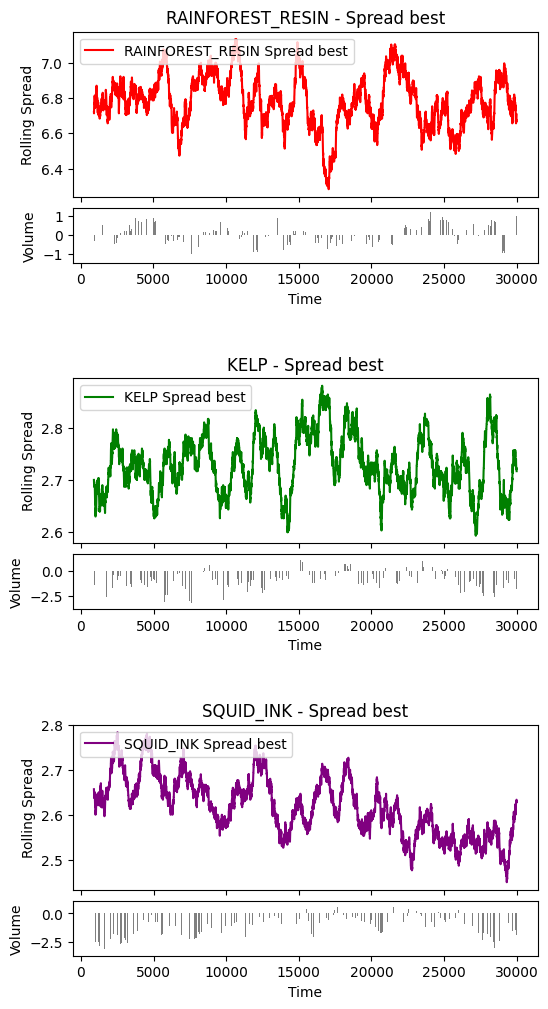

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace this with your actual data)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv",sep=",",header=0)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_day_0.csv",sep=";",header=0)


df = market_data

# Create a unique time index by combining day and timestamp
df['time_index'] = df['day'].astype(str) + '-' + df['timestamp'].astype(str)


df['spread_1'] = np.where(df['ask_price_1'].notna() & df['bid_price_1'].notna(),
                          df['ask_price_1'] - df['bid_price_1'], np.nan)

df['spread_2'] = np.where(df['ask_price_2'].notna() & df['bid_price_2'].notna(),
                          df['ask_price_2'] - df['bid_price_2'], np.nan)

df['spread_3'] = np.where(df['ask_price_3'].notna() & df['bid_price_3'].notna(),
                          df['ask_price_3'] - df['bid_price_3'], np.nan)

# Calculate best_bid and best_ask
df['ask_price_best'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].min(axis=1)
df['bid_price_best'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].max(axis=1)

# Tightes spread
df['spread_best'] = np.where(df['ask_price_best'].notna() & df['bid_price_best'].notna(),
                          df['ask_price_best'] - df['bid_price_best'], np.nan)

# Initialize columns for best bid/ask volumes
df['ask_volume_best'] = 0
df['bid_volume_best'] = 0

# Determine the best bid/ask volume
for index, row in df.iterrows():
    # Find the best ask volume
    if row['ask_price_best'] == row['ask_price_1']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_1']
    elif row['ask_price_best'] == row['ask_price_2']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_2']
    elif row['ask_price_best'] == row['ask_price_3']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_3']

    # Find the best bid volume
    if row['bid_price_best'] == row['bid_price_1']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_1']
    elif row['bid_price_best'] == row['bid_price_2']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_2']
    elif row['bid_price_best'] == row['bid_price_3']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_3']

def plot_spreads_grid(df, spreads, colors={"KELP": "green", "RAINFOREST_RESIN": "red", "SQUID_INK": "purple"}):
    products = df['product'].unique()
    n_products = len(products)
    n_spreads = len(spreads)

    fig = plt.figure(figsize=(6 * n_spreads, 4 * n_products))
    gs = fig.add_gridspec(nrows=n_products, ncols=n_spreads, height_ratios=[1]*n_products, hspace=0.5, wspace=0.3)

    

    plot_idx = 0

    for i, product in enumerate(products):
        
        color = colors.get(product, 'blue')

        for j, spread in enumerate(spreads):

            product_data = df[df['product'] == product].copy()

            spread_str = str(spread)
            spread_col = f'spread_{spread_str}'
            bid_col = f'bid_volume_{spread_str}'
            ask_col = f'ask_volume_{spread_str}'

            if spread_col not in product_data.columns:
                print(f"Warning: {spread_col} not found for {product}")
                continue

            # Compute rolling metrics
            product_data[f'{spread_col}_rolling'] = product_data[spread_col].rolling(window=300).mean()
            product_data['net_volume'] = product_data.get(ask_col, 0) - product_data.get(bid_col, 0)
            product_data['net_volume_rolling'] = product_data['net_volume'].rolling(window=300).mean()

            # Create sub-grid inside cell
            inner_gs = gs[i, j].subgridspec(2, 1, height_ratios=[3, 1], hspace=0.1)

            ax_main = fig.add_subplot(inner_gs[0])
            ax_vol = fig.add_subplot(inner_gs[1], sharex=ax_main)

            # Plot main spread
            ax_main.plot(product_data[f'{spread_col}_rolling'], label=f'{product} Spread {spread}', color=color)
            ax_main.set_ylabel('Rolling Spread')
            ax_main.set_title(f'{product} - Spread {spread}')
            ax_main.legend(loc='upper left')

            # Plot volume
            ax_vol.bar(product_data.index, product_data['net_volume_rolling'], color='black', alpha=0.5, label='Rolling Volume')
            ax_vol.set_ylabel('Volume')
            ax_vol.set_xlabel('Time')
            #ax_vol.legend(loc='upper left')

            # Reduce tick clutter
            plt.setp(ax_main.get_xticklabels(), visible=False)

    plt.tight_layout()
    plt.show()

plot_spreads_grid(df, spreads=['best'])


C:\Users\gonzaal\AppData\Local\Temp\ipykernel_3616\1240816762.py:105: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


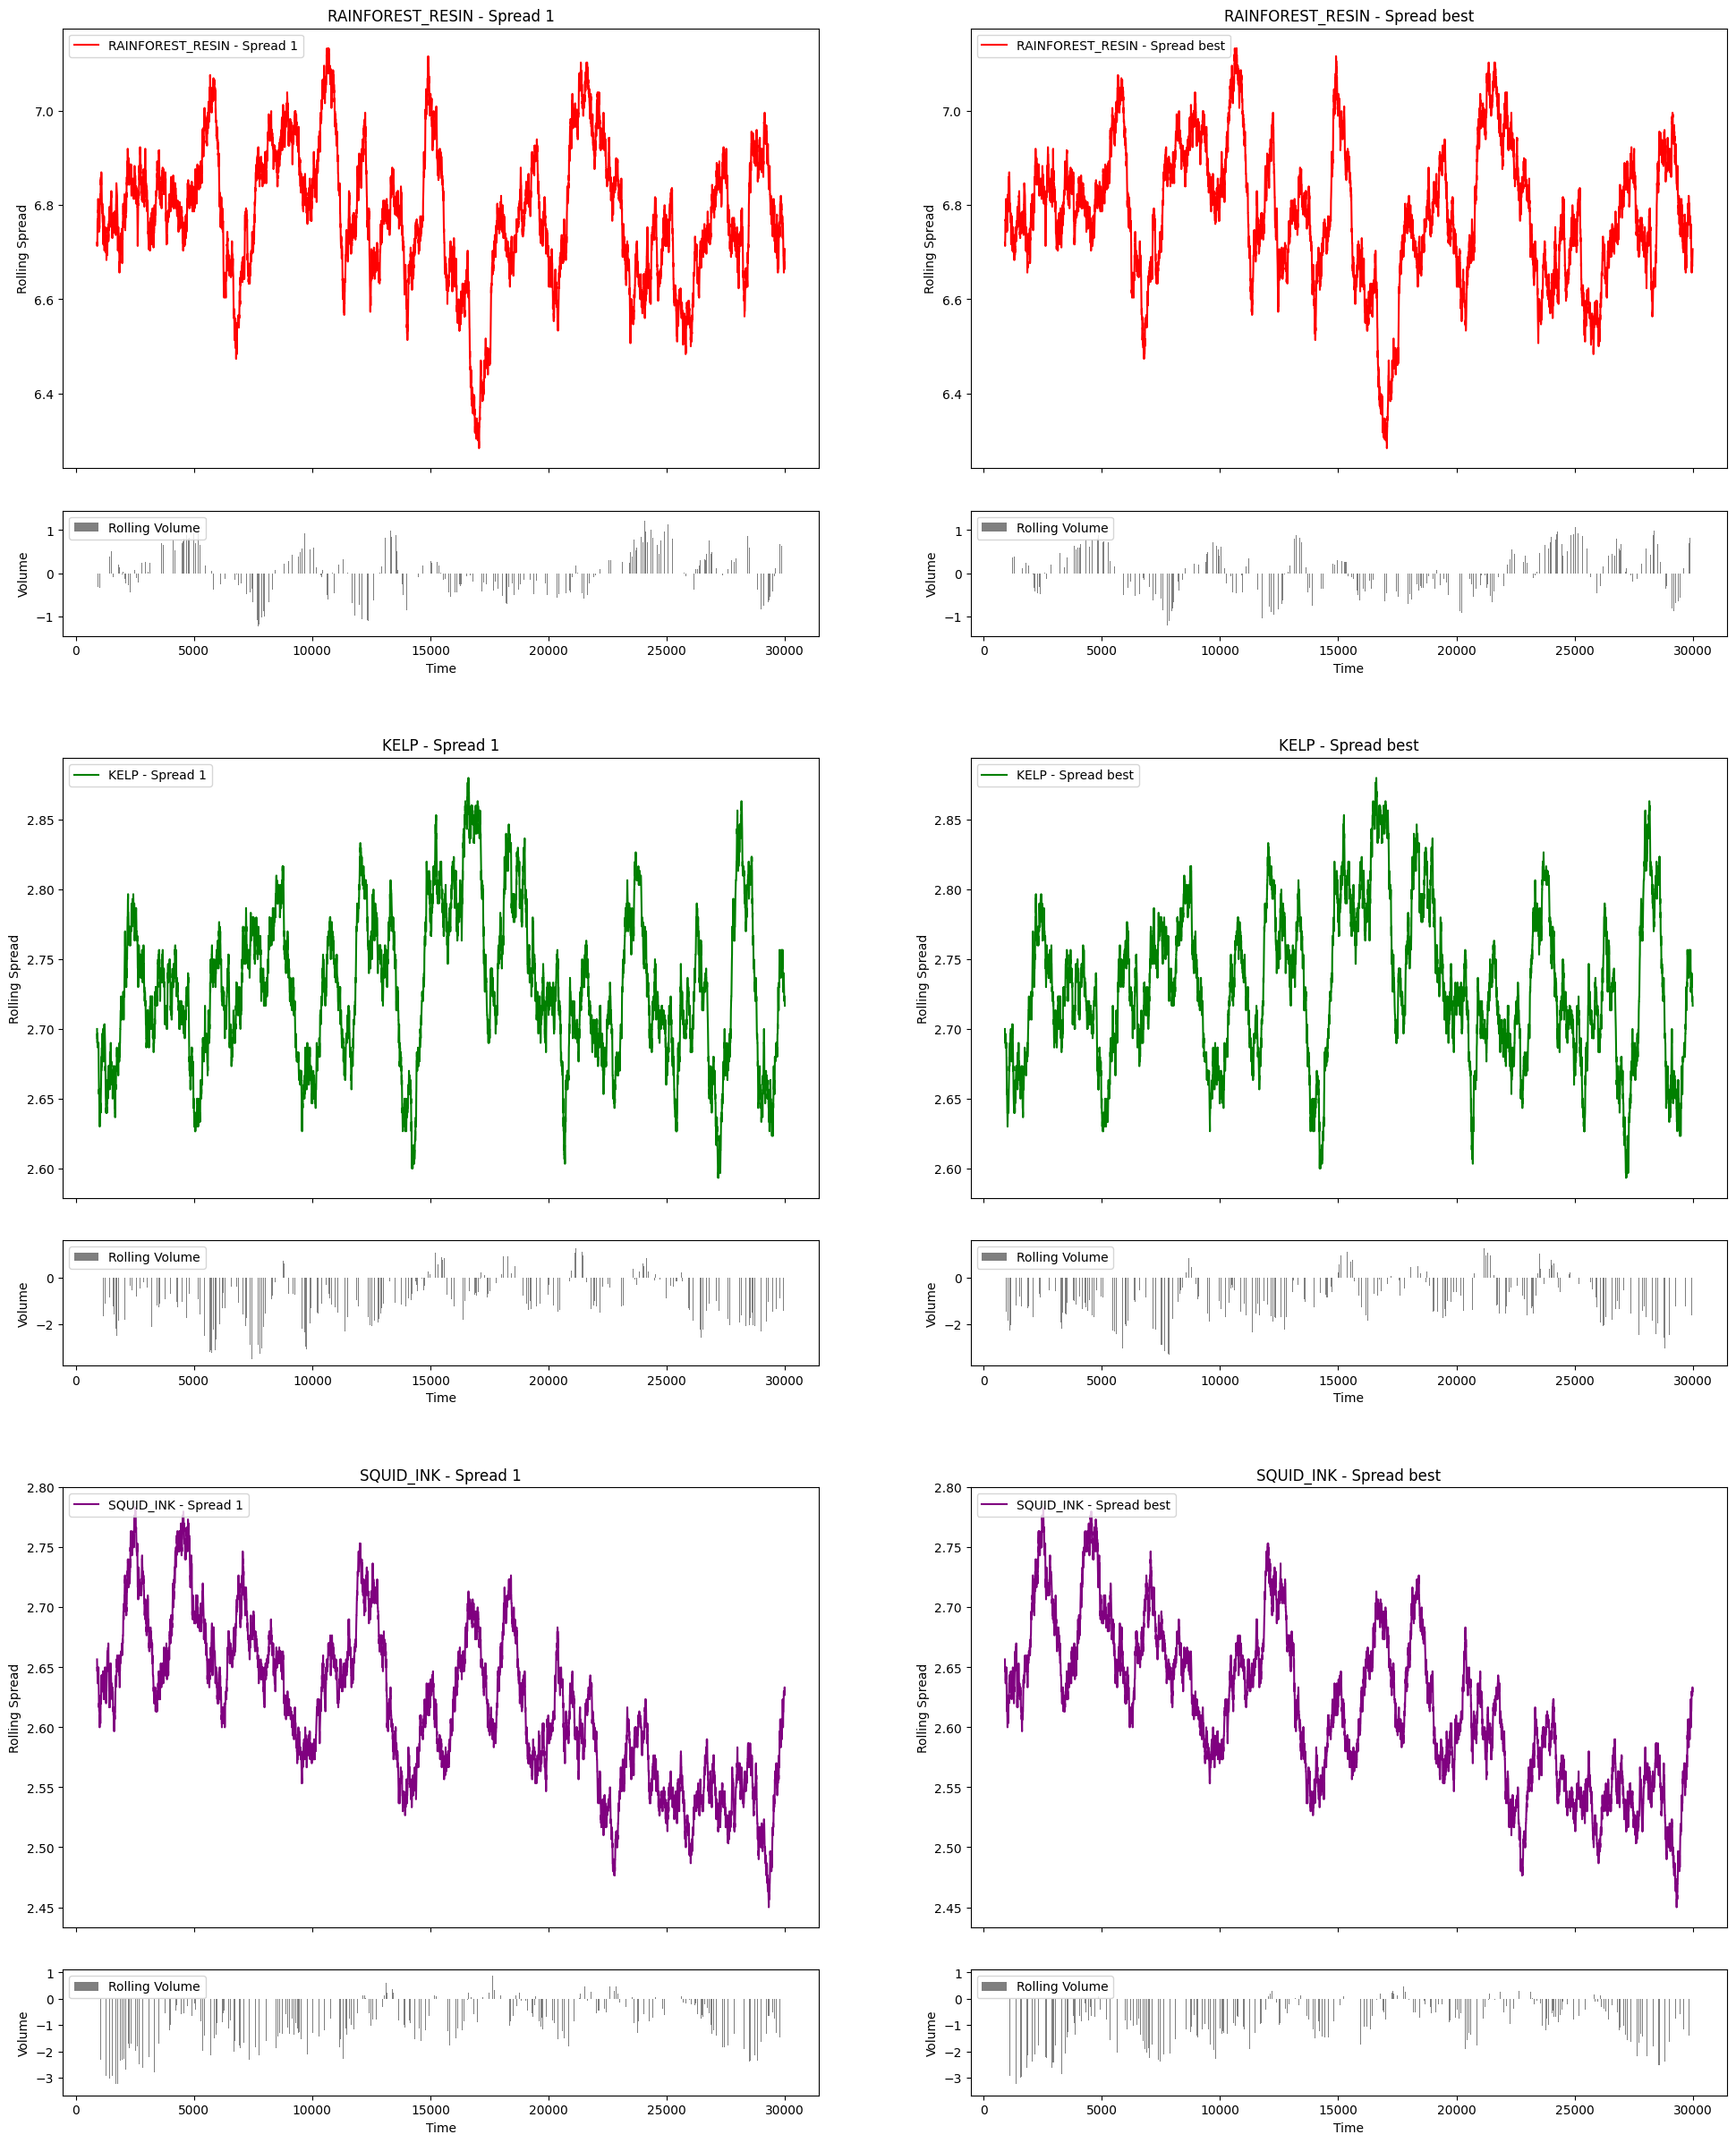

In [30]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (Replace this with your actual data)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_ALL.csv",sep=",",header=0)
market_data = pd.read_csv(r"C:\Users\gonzaal\Desktop\Personal\Personal python projects\Prosperity 3\round1\data\prices_round_1_day_0.csv",sep=";",header=0)


df = market_data

# Create a unique time index by combining day and timestamp
df['time_index'] = df['day'].astype(str) + '-' + df['timestamp'].astype(str)


df['spread_1'] = np.where(df['ask_price_1'].notna() & df['bid_price_1'].notna(),
                          df['ask_price_1'] - df['bid_price_1'], np.nan)

df['spread_2'] = np.where(df['ask_price_2'].notna() & df['bid_price_2'].notna(),
                          df['ask_price_2'] - df['bid_price_2'], np.nan)

df['spread_3'] = np.where(df['ask_price_3'].notna() & df['bid_price_3'].notna(),
                          df['ask_price_3'] - df['bid_price_3'], np.nan)

# Calculate best_bid and best_ask
df['ask_price_best'] = df[['ask_price_1', 'ask_price_2', 'ask_price_3']].min(axis=1)
df['bid_price_best'] = df[['bid_price_1', 'bid_price_2', 'bid_price_3']].max(axis=1)

# Tightes spread
df['spread_best'] = np.where(df['ask_price_best'].notna() & df['bid_price_best'].notna(),
                          df['ask_price_best'] - df['bid_price_best'], np.nan)

# Initialize columns for best bid/ask volumes
df['ask_volume_best'] = 0
df['bid_volume_best'] = 0

# Determine the best bid/ask volume
for index, row in df.iterrows():
    # Find the best ask volume
    if row['ask_price_best'] == row['ask_price_1']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_1']
    elif row['ask_price_best'] == row['ask_price_2']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_2']
    elif row['ask_price_best'] == row['ask_price_3']:
        df.at[index, 'ask_volume_best'] = row['ask_volume_3']

    # Find the best bid volume
    if row['bid_price_best'] == row['bid_price_1']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_1']
    elif row['bid_price_best'] == row['bid_price_2']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_2']
    elif row['bid_price_best'] == row['bid_price_3']:
        df.at[index, 'bid_volume_best'] = row['bid_volume_3']

def plot_spreads_grid(df, spreads, colors={"KELP": "green", "RAINFOREST_RESIN": "red", "SQUID_INK": "purple"}):
    products = df['product'].unique()
    n_products = len(products)
    n_spreads = len(spreads)

    # Dynamic width: wider figure if only 1 spread
    fig_width = 16 if n_spreads == 1 else 12 * n_spreads
    fig_height = 10 * n_products  # Increased from 4 to 5
    fig = plt.figure(figsize=(fig_width, fig_height))
    outer_gs = fig.add_gridspec(n_products, n_spreads, wspace=0.2, hspace=0.2)

    for i, product in enumerate(products):
        for j, spread in enumerate(spreads):
            product_data = df[df['product'] == product].copy()
            
            spread_str = str(spread)
            spread_col = f'spread_{spread_str}'
            bid_col = f'bid_volume_{spread_str}'
            ask_col = f'ask_volume_{spread_str}'

            if spread_col not in product_data.columns:
                print(f"Warning: {spread_col} not found for product {product}. Skipping.")
                continue

            product_data[f'{spread_col}_rolling'] = product_data[spread_col].rolling(window=300).mean()
            product_data[f'bid_volume_{spread_str}_rolling'] = product_data[bid_col].rolling(window=300).mean()
            product_data[f'ask_volume_{spread_str}_rolling'] = product_data[ask_col].rolling(window=300).mean()
            product_data['net_volume'] = product_data[ask_col] - product_data[bid_col]
            product_data['net_volume_rolling'] = product_data['net_volume'].rolling(window=300).mean()

            inner_gs = outer_gs[i, j].subgridspec(2, 1, height_ratios=[7, 2], hspace=0.15)
            ax_main = fig.add_subplot(inner_gs[0])
            ax_vol = fig.add_subplot(inner_gs[1], sharex=ax_main)

            color = colors.get(product, 'blue')
            ax_main.plot(product_data[f'{spread_col}_rolling'], label=f'{product} - Spread {spread_str}', color=color)
            ax_main.set_ylabel('Rolling Spread')
            ax_main.set_title(f'{product} - Spread {spread_str}')
            ax_main.legend(loc='upper left')
            plt.setp(ax_main.get_xticklabels(), visible=False)

            ax_vol.bar(product_data.index, product_data['net_volume_rolling'], color='black', alpha=0.5, label='Rolling Volume')
            ax_vol.set_ylabel('Volume')
            ax_vol.set_xlabel('Time')
            ax_vol.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_spreads_grid(df, spreads=[1,'best'])

In [31]:
market_data[(~market_data['ask_price_2'].isna()) & (~market_data['bid_price_2'].isna())]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,profit_and_loss,time_index,spread_1,spread_2,spread_3,ask_price_best,bid_price_best,spread_best,ask_volume_best,bid_volume_best
5,0,100,RAINFOREST_RESIN,9996,1,9995.0,30.0,NaN,NaN,10002,...,0.0,0-100,6.0,9.0,NaN,10002.0,9996.0,6.0,6,1
7,0,200,RAINFOREST_RESIN,9996,1,9995.0,21.0,NaN,NaN,10004,...,0.0,0-200,8.0,10.0,NaN,10004.0,9996.0,8.0,1,1
11,0,300,RAINFOREST_RESIN,9996,2,9995.0,23.0,NaN,NaN,9998,...,0.0,0-300,2.0,9.0,NaN,9998.0,9996.0,2.0,3,2
12,0,400,RAINFOREST_RESIN,9998,5,9996.0,2.0,9995.0,23.0,10004,...,0.0,0-400,6.0,9.0,NaN,10004.0,9998.0,6.0,2,5
13,0,400,KELP,2029,2,2028.0,23.0,NaN,NaN,2030,...,0.0,0-400,1.0,4.0,NaN,2030.0,2029.0,1.0,6,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29980,0,999300,RAINFOREST_RESIN,9996,1,9995.0,26.0,NaN,NaN,10004,...,0.0,0-999300,8.0,10.0,NaN,10004.0,9996.0,8.0,1,1
29988,0,999600,RAINFOREST_RESIN,9996,2,9995.0,27.0,NaN,NaN,10002,...,0.0,0-999600,6.0,9.0,NaN,10002.0,9996.0,6.0,3,2
29989,0,999600,SQUID_INK,1832,7,1831.0,29.0,NaN,NaN,1834,...,0.0,0-999600,2.0,4.0,NaN,1834.0,1832.0,2.0,2,7
29992,0,999700,RAINFOREST_RESIN,9996,2,9995.0,24.0,NaN,NaN,10004,...,0.0,0-999700,8.0,10.0,NaN,10004.0,9996.0,8.0,2,2


In [32]:
market_data[(~market_data['ask_price_3'].isna()) & (~market_data['bid_price_3'].isna())]

,day,timestamp,product,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,...,profit_and_loss,time_index,spread_1,spread_2,spread_3,ask_price_best,bid_price_best,spread_best,ask_volume_best,bid_volume_best
411,0,13700,RAINFOREST_RESIN,10000,2,9996.0,2.0,9995.0,28.0,10002,...,0.0,0-13700,2.0,8.0,10.0,10002.0,10000.0,2.0,7,2
458,0,15200,RAINFOREST_RESIN,9998,3,9996.0,2.0,9995.0,23.0,10000,...,0.0,0-15200,2.0,8.0,10.0,10000.0,9998.0,2.0,4,3
899,0,29900,RAINFOREST_RESIN,9998,8,9996.0,1.0,9995.0,26.0,10000,...,0.0,0-29900,2.0,8.0,10.0,10000.0,9998.0,2.0,2,8
2607,0,86900,RAINFOREST_RESIN,9998,7,9996.0,2.0,9995.0,30.0,10000,...,0.0,0-86900,2.0,8.0,10.0,10000.0,9998.0,2.0,2,7
3844,0,128100,RAINFOREST_RESIN,9998,5,9996.0,2.0,9995.0,23.0,10000,...,0.0,0-128100,2.0,8.0,10.0,10000.0,9998.0,2.0,2,5
4239,0,141300,RAINFOREST_RESIN,10000,3,9996.0,1.0,9995.0,20.0,10002,...,0.0,0-141300,2.0,8.0,10.0,10002.0,10000.0,2.0,7,3
4892,0,163000,RAINFOREST_RESIN,9998,8,9996.0,1.0,9995.0,26.0,10000,...,0.0,0-163000,2.0,8.0,10.0,10000.0,9998.0,2.0,6,8
8514,0,283800,RAINFOREST_RESIN,9998,7,9996.0,1.0,9995.0,21.0,10000,...,0.0,0-283800,2.0,8.0,10.0,10000.0,9998.0,2.0,5,7
8568,0,285600,RAINFOREST_RESIN,10000,5,9996.0,2.0,9995.0,24.0,10002,...,0.0,0-285600,2.0,8.0,10.0,10002.0,10000.0,2.0,10,5
9522,0,317400,RAINFOREST_RESIN,9998,9,9996.0,1.0,9995.0,28.0,10000,...,0.0,0-317400,2.0,8.0,10.0,10000.0,9998.0,2.0,5,9
